<a href="https://colab.research.google.com/github/Ariostgx/fairgen/blob/main/docs/fairgen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fetch Codebase and Models

In [1]:
#@title Click left to featch code and models
import os
os.chdir('/content')

# # featch model codebase
CODE_DIR = 'fairgen'
os.makedirs(f'./{CODE_DIR}', exist_ok=True)
!git clone https://github.com/Ariostgx/fairgen_model.git $CODE_DIR
os.chdir('/content/fairgen')

# fetch GMM models
GMM_DIR = 'gmms'
os.makedirs(f'./{GMM_DIR}', exist_ok=True)
!gdown https://drive.google.com/uc?id=1qgU07dFEOuTqm6NduFVmi7a8u-hDTddb -O $GMM_DIR/age_eyeglasses_gmm.p
!gdown https://drive.google.com/uc?id=1atIfXaKh97o5jRT73oMrlm5_guQXyh3D -O $GMM_DIR/age_gender_gmm.p
!gdown https://drive.google.com/uc?id=1nIbyrhCkSh9qulrJLFWKasTfmoxoWnYs -O $GMM_DIR/age_smiling_gmm.p
!gdown https://drive.google.com/uc?id=1TLMZZyG2fdDPDbxvqXlUeIUo3ag7zetp -O $GMM_DIR/gender_black_hair_gmm.p
!gdown https://drive.google.com/uc?id=1whwcTRloZZQ5G2mv7TrBuV4Ffu38djxc -O $GMM_DIR/gender_eyeglasses_gmm.p

fatal: destination path 'fairgen' already exists and is not an empty directory.
Downloading...
From: https://drive.google.com/uc?id=1qgU07dFEOuTqm6NduFVmi7a8u-hDTddb
To: /content/fairgen/gmms/age_eyeglasses_gmm.p
252MB [00:00, 254MB/s]
Downloading...
From: https://drive.google.com/uc?id=1atIfXaKh97o5jRT73oMrlm5_guQXyh3D
To: /content/fairgen/gmms/age_gender_gmm.p
252MB [00:00, 259MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nIbyrhCkSh9qulrJLFWKasTfmoxoWnYs
To: /content/fairgen/gmms/age_smiling_gmm.p
252MB [00:00, 260MB/s]
Downloading...
From: https://drive.google.com/uc?id=1TLMZZyG2fdDPDbxvqXlUeIUo3ag7zetp
To: /content/fairgen/gmms/gender_black_hair_gmm.p
252MB [00:02, 106MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1whwcTRloZZQ5G2mv7TrBuV4Ffu38djxc
To: /content/fairgen/gmms/gender_eyeglasses_gmm.p
252MB [00:04, 60.2MB/s]


# Define Utility Functions


In [2]:
import subprocess
import io
import IPython.display
import numpy as np
import cv2
import PIL.Image
import torch
import pickle

from models import MODEL_ZOO
from models import build_generator

import warnings
warnings.filterwarnings("ignore")

def imshow(images, col, viz_size=256):
  """Shows images in one figure."""
  num, height, width, channels = images.shape
  assert num % col == 0
  row = num // col
  fused_image = np.zeros((viz_size * row, viz_size * col, channels), dtype=np.uint8)
  for idx, image in enumerate(images):
    i, j = divmod(idx, col)
    y = i * viz_size
    x = j * viz_size
    if height != viz_size or width != viz_size:
      image = cv2.resize(image, (viz_size, viz_size))
    fused_image[y:y + viz_size, x:x + viz_size] = image
  fused_image = np.asarray(fused_image, dtype=np.uint8)
  data = io.BytesIO()
  PIL.Image.fromarray(fused_image).save(data, 'jpeg')
  im_data = data.getvalue()
  disp = IPython.display.display(IPython.display.Image(im_data))
  return disp

def build(model_name, use_cuda=False):
  """Builds generator and load pre-trained weights."""
  model_config = MODEL_ZOO[model_name].copy()
  url = model_config.pop('url')  # URL to download model if needed.

  # Build generator.
  print(f'Building generator for model `{model_name}` ...')
  generator = build_generator(**model_config, use_cuda = use_cuda)
  print(f'Finish building generator.')

  # Load pre-trained weights.
  os.makedirs('checkpoints', exist_ok=True)
  checkpoint_path = os.path.join('checkpoints', model_name + '.pth')
  print(f'Loading checkpoint from `{checkpoint_path}` ...')
  if not os.path.exists(checkpoint_path):
    print(f'  Downloading checkpoint from `{url}` ...')
    subprocess.call(['wget', '--quiet', '-O', checkpoint_path, url])
    print(f'  Finish downloading checkpoint.')
  checkpoint = torch.load(checkpoint_path, map_location='cpu')
  if 'generator_smooth' in checkpoint:
    generator.load_state_dict(checkpoint['generator_smooth'])
  else:
    generator.load_state_dict(checkpoint['generator'])
  if use_cuda:
      generator = generator.cuda()
  generator.eval()
  print(f'Finish loading checkpoint.')
  return generator

def sample_codes(generator, num):
  """Samples latent codes randomly."""
  codes = generator.easy_sample(num)
  codes = torch.from_numpy(codes).type(torch.FloatTensor).to(generator.run_device)
  codes = generator.get_value(generator.mapping(codes, None)['w'])
  return codes

loaded_pair = ''

# Build GAN model

In [3]:
model_name = 'stylegan2_ffhq1024'
generator = build(model_name, use_cuda=True)

Building generator for model `stylegan2_ffhq1024` ...
Finish building generator.
Loading checkpoint from `checkpoints/stylegan2_ffhq1024.pth` ...
Finish loading checkpoint.


# Direct sample images from GAN

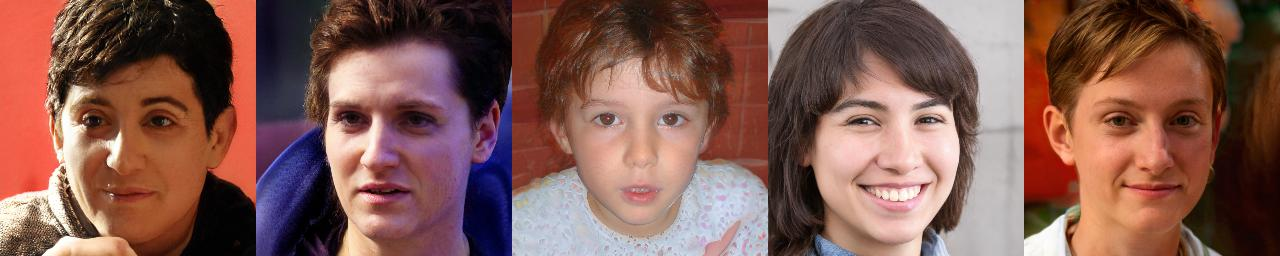

In [18]:

#@title { display-mode: "form", run: "auto" }

num_samples = 5 #@param {type:"slider", min:1, max:8, step:1}
codes = sample_codes(generator, num_samples)

images = generator(codes, latent_space_type='W')['image']
imshow(images, col=num_samples)

# Select subgroup GMM model


---


| Attribute | value=-1 | value=1 |
|-----|-----|-----|
| <img width=100/>Age<img width=100/> | <img width=50/>young<img width=50/> | <img width=50/>adult<img width=50/> |
| <img width=100/>Gender<img width=100/> | <img width=50/>male<img width=50/> | <img width=50/>female<img width=50/> |
| <img width=100/>Eyeglasses<img width=100/> | <img width=50/>with<img width=50/> | <img width=50/>without<img width=50/> |
| <img width=100/>Black Hair<img width=100/> | <img width=50/>with<img width=50/> | <img width=50/>without<img width=50/> |
| <img width=100/>Smiling<img width=100/> | <img width=50/>with<img width=50/> | <img width=50/>without<img width=50/> |



In [29]:
#@title { display-mode: "form", run: "auto" }
attribute_pair = "Age vs Eyeglasses" #@param ['Age vs Eyeglasses','Age vs Gender', 'Age vs Smiling', 'Gender vs Black_Hair', 'Gender vs Eyeglasses']
attr_1_value = "-1" #@param ['-1', '1']
attr_2_value = "-1" #@param ['-1', '1']


attr_names = attribute_pair.lower().split(' ')
attr_pair_name = "{}_{}".format(attr_names[0], attr_names[2])

if loaded_pair != attribute_pair:
  gmm_path = f'gmms/{attr_pair_name}_gmm.p'
  gmm_models = pickle.load(open(gmm_path, 'rb'))
  loaded_pair = attribute_pair

attr_value_name = '{:.1f}_{:.1f}'.format(int(attr_1_value)*3.0, int(attr_2_value)*3.0)
gmm_model = gmm_models[attr_value_name]

# Conditional sample subgroup images

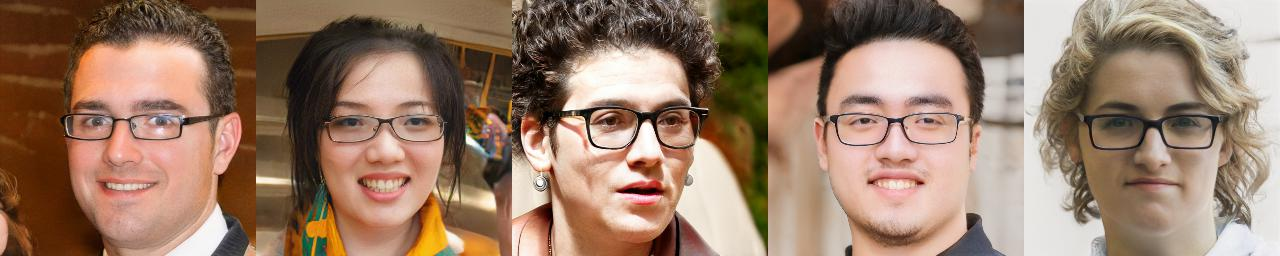

In [33]:

#@title { display-mode: "form", run: "auto" }

num_samples = 5 #@param {type:"slider", min:1, max:8, step:1}
codes = gmm_model.sample(num_samples)[0]

images = generator(codes, latent_space_type='W')['image']
imshow(images, col=num_samples)

# Fair sample of the specified attribute pair


Young Age and With Eyeglasses


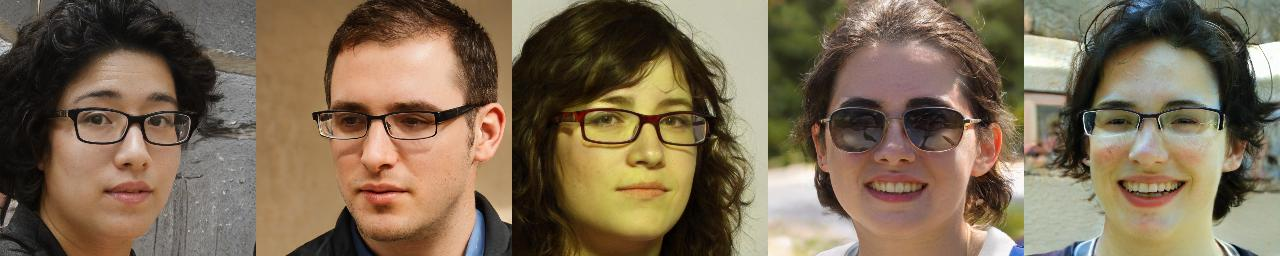

Young Age and Without Eyeglasses


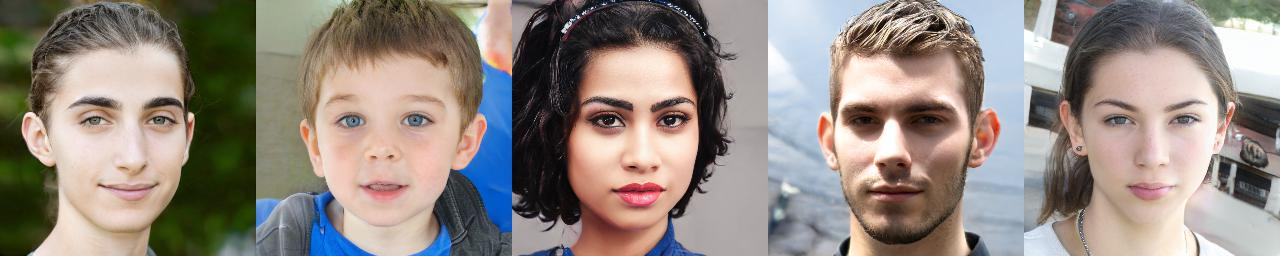

Adult Age and With Eyeglasses


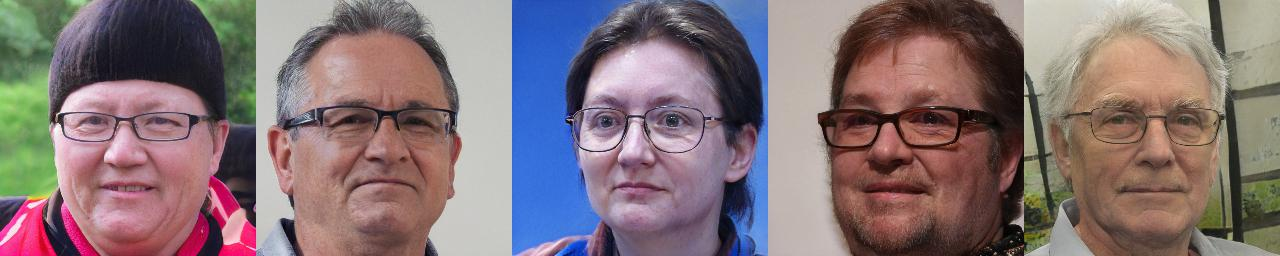

Adult Age and Without Eyeglasses


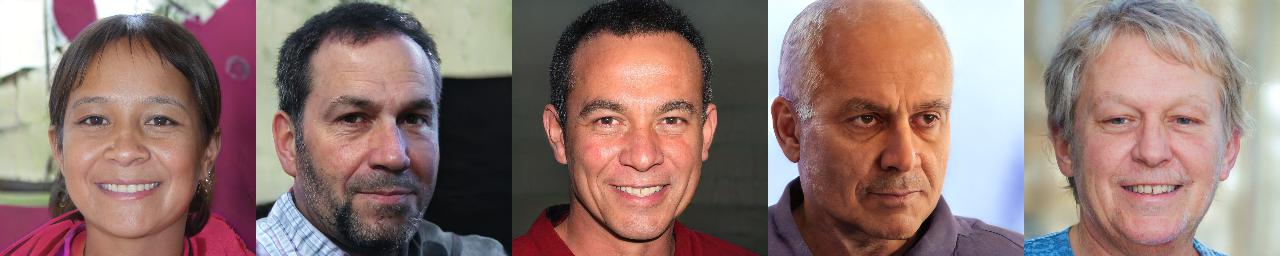

In [26]:
#@title { display-mode: "form", run: "auto" }
num_samples = 5 #@param {type:"slider", min:1, max:8, step:1}

value_name = {'Age': {-1: 'Young', 1: 'Adult'}, 'Gender': {-1: 'Male', 1: 'Female'}, 'Smiling': {-1: 'With', 1: 'Without'}}
for attr in ['Eyeglasses', 'Black_Hair']:
  value_name[attr] = value_name['Smiling']

attr_1,_,attr_2 = attribute_pair.split(' ')

for attr_1_value in [-1, 1]:
  for attr_2_value in [-1, 1]:
    print("{} {} and {} {}".format(value_name[attr_1][attr_1_value], attr_1, value_name[attr_2][attr_2_value], attr_2))

    attr_value_name = '{:.1f}_{:.1f}'.format(int(attr_1_value)*3.0, int(attr_2_value)*3.0)
    gmm_model = gmm_models[attr_value_name]
    codes = gmm_model.sample(num_samples)[0]
    images = generator(codes, latent_space_type='W')['image']
    imshow(images, col=num_samples)